# Moro robustness optimization

In this notebook Moro optimization will be used to find robust policies, that perform well under a wide variety of scenarios.

The notebook consists of 3 major parts:
  1. _Generate random policies_, in which random policies will be generated to see how many scenarios each policy need before the KPIs converge
  2. _Determine KPI cutoff values_, in which cutoff values for the three KPIs will be fine-tuned
  3. _Search for robust candidate solutions_, in which potential robust policies will be searched and found
  4. _Re-evaluate candidate solutions under uncertainty_, to check if the potential policies are actually robust under a higher number of scenarios

3 main KPIs will be used to find these robust policies:

| KPI                           | Max value            | Optimization direction |
|-------------------------------|----------------------|------------------------|
| A.3 Total Costs               | € 170 million        | Minimize               |
| A.3_Expected Number of Deaths | 0.2 (0.001 per year) | Minimize               |
| RfR Total Costs               | € 1950 million       | Minimize               |

## 1. Generate random policies

In this section random policies will be generated to see how many scenarios each policy need before the KPIs converge. First the KPIs are defined, then a function to evaluate if a outcome is robust is defined, the model is generated for our problem formulation, 25 random policies are run for 250 scenarios (generated using latin hypercube sampling) to see how and when the KPIs converged. From that, a computationally acceptable value for the number of scenarios is picked based on how quickly the KPIs converged.

In [1]:
# Necessary imports
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import functools

from ema_workbench import ema_logging, MultiprocessingEvaluator, SequentialEvaluator, Samplers

In [2]:
# Set seed to 0 to make notebook reproducable
np.random.seed(0)

In [3]:
# Define the KPIs
years = 200                     # Current preferred timeframe
A3_deaths_per_year = 0.001      # Translates roughly 1 in 100:000 yearly chance of dike breakage in A.3 ring
max_A3_total_costs = 170000000  # Our max preferred costs, based on the potential compensation of Rijkswaterstaat
max_rfr_costs = 1950000000      # Rijkswaterstaat budget of 2.3 billion minus 350 million for our compensation

In [4]:
# Define the robustness function (which evaluates when some outcome is considered acceptable)
def robustness(smaller, threshold, data):
    if smaller:
        return np.sum(data <= threshold) / data.shape[0]
    else:
        return np.sum(data >= threshold) / data.shape[0]

# Define partial functions used to evaluate against
A3_total_costs = functools.partial(robustness, True, max_A3_total_costs)
A3_number_of_deaths = functools.partial(robustness, True, A3_deaths_per_year*years)
RfR_total_costs = functools.partial(robustness, True, max_rfr_costs)

Based on our KPIs problem formulation 3 is the most applicable. It contains information about deaths and costs for the A.3 dike ring. However, it contains a lot of other outcome metrics, which is a potential disadvantage if aggerated metrics are required.

In [5]:
from problem_formulation import get_model_for_problem_formulation

# Get the model for problem formulation 3
model, _ = get_model_for_problem_formulation(3)

In [6]:
# Logging is enabled for debugging purposes
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

#### Test at which number of scenarios KPIs converge

With our KPIs defined and model formulated 10 random policies are generated and evaluated over 250 scenarios to see when the KPIs converge to a stable average value. To generate the scenarios, latin hypercube sampling (LHS) is used to ensure a nice spread of scenarios among the uncertainty space, while leaving some randomness in there.

The number of policies and scenarios have been experimentally determined, 25 policies deemed enough to see how multiple different policies stabilize and 250 scenarios was more than enough to see proper convergence of KPIs.

Note that in this notebook [Pickles](https://docs.python.org/3/library/pickle.html) are used to store evaluator results. This allows to quickly iterate on (someone else's) notebook without having to rerun the evaluators each time. If `use_pickle` is set to `True`, the data is loaded from the Pickle file, otherwise the evaluator is run again.

In [7]:
use_pickle1 = True  # Define if the results are loaded or the evaluator is run again
if use_pickle1:
    # Load results from Pickle
    with open('data/moro_rob_results1.pickle', 'rb') as filehandler:
        results1 = pickle.load(filehandler)
else:
    # Run the evaluator to generate new results
    with MultiprocessingEvaluator(model, n_processes=14) as evaluator:
        results1 = evaluator.perform_experiments(scenarios=250,
                                                 policies=10,
                                                 uncertainty_sampling=Samplers.LHS)
        # Save the new results in the Pickle file
        with open("data/moro_rob_results1.pickle","wb") as filehandler:
            pickle.dump(results1, filehandler)

To see when KPI convergence is achieved, the average values of each KPI are plotted cumulative with each added scenario.

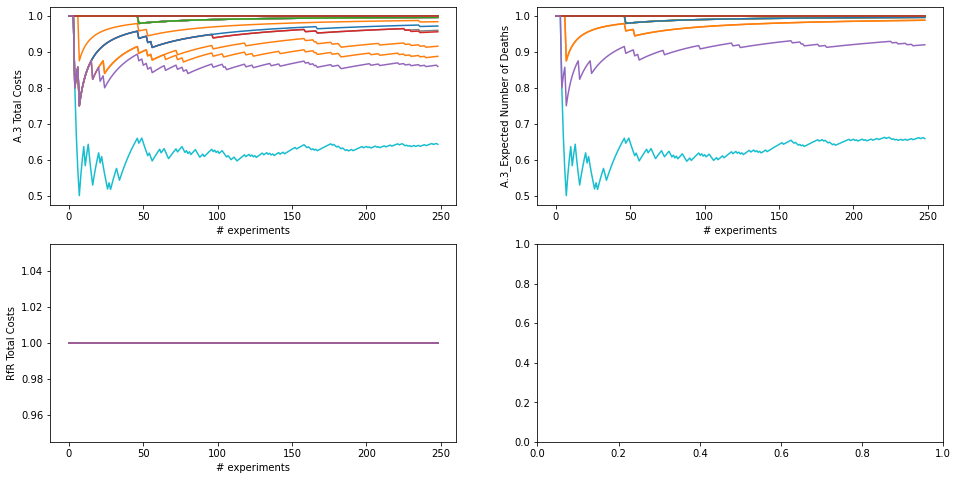

In [8]:
# Define figure with subplots and axes
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(16,8), sharex=False)
axes = [axes[0,0],axes[0,1],axes[1,0]]

# Define a dictionary linking the outcome keys to the robustness functions
robustness_funcs = {'A.3 Total Costs': A3_total_costs,
                    'A.3_Expected Number of Deaths': A3_number_of_deaths,
                    'RfR Total Costs': RfR_total_costs}

# Split the results tuple in experiments and outcomes
experiments, outcomes = results1

# Select only the outcomes that are also our KPIs
plot_outcomes = {o:v for o,v in outcomes.items() if o in robustness_funcs.keys()}

# Create a subplot for each KPI
for ax, (outcome, value) in zip(axes, plot_outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]

        robustness_p = []

        for i in range(1, data.shape[0]):
            robustness_p.append(robustness_funcs[outcome](data[0:i]))
        ax.plot(robustness_p, label=policy)
    ax.set_xlabel("# experiments")
    ax.set_ylabel(outcome)
plt.savefig("images/MORO/MORO_1a_KPI_convergence.png", dpi=200, bbox_inches='tight',format="png")

From the graph above it can be concluded that at least 40 scenarios are needed per policy for the A.3 Total Costs and Expected Number of Deaths to stabilize, and preferably closer to 80 to 100.

## 2. Determine KPI cutoff values

With the number of scenarios needed for convergence established, searching for candidate solutions (potential policies) can start. 50 different policies are generated randomly as a test set and each run over 40 scenarios. The results are visualised, to determine reasonable cutoff values for our KPIs.

In [9]:
# Define evaluator parameters
n_scenarios = 40     # Original value: 10 scenarios
n_policies = 50      # Original value: 100 policies
nfe = int(1000)      # Original value: 1000 nfe

In [10]:
from ema_workbench.em_framework import sample_uncertainties

# Generate set of scenarios
scenarios = sample_uncertainties(model, n_scenarios)

In [11]:
from ema_workbench import (Model, CategoricalParameter, ScalarOutcome, IntegerParameter, RealParameter)

In [12]:
use_pickle2 = True
if use_pickle2:
    with open('data/moro_rob_results2.pickle', 'rb') as filehandler:
        results2 = pickle.load(filehandler)
else:
    with MultiprocessingEvaluator(model, n_processes=14) as evaluator:
        results2 = evaluator.perform_experiments(scenarios=n_scenarios,
                                                 policies=n_policies,
                                                 uncertainty_sampling=Samplers.LHS)
        # Save results in Pickle file
        with open("data/moro_rob_results2.pickle","wb") as filehandler:
            pickle.dump(results2, filehandler)

With the experiments ran violin plots are generated to see how the KPIs are distributed between the experiments. Each plot displays the density of the experiments around a certain outcome value, using kernel density estimation. Also a 90th or higher percentile is calculated to give an upper bound. The 96th percentile is calculated for the 3 KPIs to give an indication where 1/25th of the experiments can be excluded.

Note the logaritmic scale for the A.3 Total Costs and A.3_Expected Number of Deaths KPIs.

In [13]:
# Set a seaborn theme with gridlines
sns.set_theme(style="whitegrid")

96th percentile of A.3 Total Costs is: 152430557.99


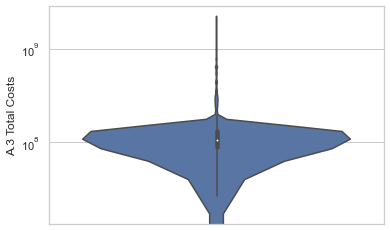

In [14]:
# Define the percentile to print and KPI to plot
percentile = 96
KPI = 'A.3 Total Costs'

# Add policies to dataframe and print upper percentile
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
print(f"{percentile}th percentile of {KPI} is: {np.percentile(data[KPI], percentile):.2f}")

# Create and save violin plot
ax = sns.violinplot(data=data, y=KPI)
ax.set_yscale('log')
plt.savefig("images/MORO/MORO_2a_violin_A3_costs.png", dpi=300, bbox_inches='tight',format="png")

96th percentile of A.3_Expected Number of Deaths is: 0.0530


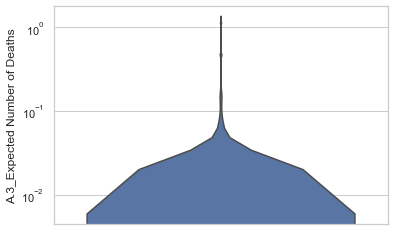

In [15]:
# Define the percentile to print and KPI to plot
percentile = 96
KPI = 'A.3_Expected Number of Deaths'

# Add policies to dataframe and print upper percentile
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
print(f"{percentile}th percentile of {KPI} is: {np.percentile(data[KPI], percentile):.4f}")

# Create and save violin plot
ax = sns.violinplot(data=data, y=KPI)
ax.set_yscale('log')
plt.savefig("images/MORO/MORO_2a_violin_A3_deaths.png", dpi=300, bbox_inches='tight',format="png")

96th percentile of RfR Total Costs is: 1682920000.00


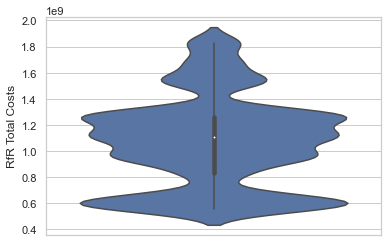

In [16]:
# Define the percentile to print and KPI to plot
percentile = 96
KPI = 'RfR Total Costs'

# Add policies to dataframe and print upper percentile
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
print(f"{percentile}th percentile of {KPI} is: {np.percentile(data[KPI], percentile):.2f}")

# Create and save violin plot
ax = sns.violinplot(data=data, y=KPI)
#ax.set_yscale('log')
plt.savefig("images/MORO/MORO_2a_violin_RfR_costs.png", dpi=300, bbox_inches='tight',format="png")

The violin plots above show (together with the 96th percentile) that in the vast majority of cases, the A.3 total costs stay below 150 million euros, while the Room for River (RfR) total costs stay below 1.7 billion. These numbers are quite close (within 20%) of je aimed 170 million and 1.95 billion respectively. Noteable is that the A.3 total costs is quite densely packed around the 100 million range, while the RfR costs are more abitraily distributed, with high-density clusters around 0.6, 1.1 and 1.6 billion euros.
 
The number of deaths in the A.3 dike ring however stay in a much low range for the vast majority of outcomes. The 96th percentile is around 0.053, meaning on average over 200 years only 0.000265 deaths per year.

Based on this analysis of realistic cutoff values, we would like the number of deaths in the A.3 dike ring to decrease the most. We also would like a bit cheaper costs for ourselves, and think we can rally more support by other actors if the total costs decrease. This way we still cover the vast majority of the outcome space which should lead to robust policies.

| KPI                           | Max value (initial)  | Max value (current)     | Optimization direction |
|-------------------------------|----------------------|-------------------------|------------------------|
| A.3 Total Costs               | € 170 million        | € 150 million           | Minimize               |
| A.3_Expected Number of Deaths | 0.2 (0.001 per year) | 0.05 (0.00025 per year) | Minimize               |
| RfR Total Costs               | € 1950 million       | € 1700 million          | Minimize               |

#### Evaluate new KPIs

To evaluate the policies on our new KPIs, a parallel axis plot created. In this plot, for each KPI and each policy the percentage of scenarios that perform acceptable on our KPIs can be seen.

In [17]:
# Define the new KPIs
years = 200                     # Current preferred timeframe
A3_deaths_per_year = 0.00025    # Translates roughly 1 in 250.000 yearly chance of dike breakage in A.3 ring
max_A3_total_costs = 150000000  # Our max preferred costs, based on the potential compensation of Rijkswaterstaat
max_rfr_costs = 1700000000      # Rijkswaterstaat budget of 2.3 billion minus 350 million for our compensation

In [18]:
# Define partial functions used to evaluate against
A3_total_costs = functools.partial(robustness, True, max_A3_total_costs)
A3_number_of_deaths = functools.partial(robustness, True, A3_deaths_per_year*years)
RfR_total_costs = functools.partial(robustness, True, max_rfr_costs)

With those new KPIs we can create a new parallel axis plot to evaluate the policies on the KPIs.

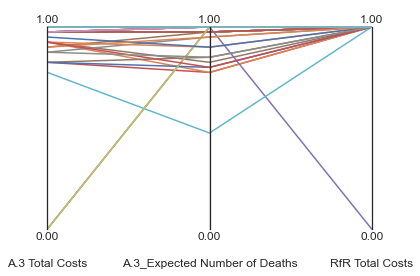

In [19]:
from ema_workbench.analysis import parcoords

# Split the results tuple
experiments, outcomes = results2

# Define function dictionary again
funcs = {'A.3 Total Costs': A3_total_costs,
         'A.3_Expected Number of Deaths': A3_number_of_deaths,
         'RfR Total Costs': RfR_total_costs}

# Calculate the scores for each policy
total_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy'] == policy
    
    temp_outcomes = {k:v[logical] for k,v in outcomes.items() if k in robustness_funcs}
    
    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

# Transform and normalize the results dataframe
data = pd.DataFrame(total_scores).T.reset_index(drop=True)
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

# Create parallel axis plot
paraxes = parcoords.ParallelAxes(limits, fontsize=12, rot=0)
paraxes.plot(data)
plt.savefig("images/MORO/MORO_2b_random_policies_ParallelAxes.png", dpi=300, bbox_inches='tight',format="png")

In the parallel axis plot it can be observed that there are many policies which have high rates of scenarios scoring acceptable on A.3 Total Costs and A.3 Expected Number of Deaths. Note that RfR costs are not stochastic and thus identical for each scenario. Only one of the 50 policies doesn't make the cut according to our new KPI values.

## 3. Search for robust candidate solutions

With the tuned KPI cuttoff values found and deemed reasonable, robustness optimization can now be run. First values for epsilon will be calculated.

The epsilon values for each KPI are determined by a fraction of the maximum required value. This way not too many similar policies will be created.

In [20]:
# Define epsilon values
#epsilon_fraction = 25
#KPI_max_list = [max_A3_total_costs, A3_deaths_per_year*years, max_rfr_costs]
#print(f"Max KPI preferred: {KPI_max_list}")

#epsilons = [i/epsilon_fraction for i in KPI_max_list]
#print(f"Epsilon values: {epsilons}")

In [21]:
epsilons = [0.001]*len(model.outcomes)

In [22]:
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume

# Define the converge metric
convergence = [EpsilonProgress()]
#convergence = [EpsilonProgress(), HyperVolume(minimum=[0,0,0], maximum=[1.1, 1.1, 1.1])]

# Define the KPI goals
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

# Define the function dictionary
funcs = {'A.3 Total Costs': A3_total_costs,
         'A.3_Expected Number of Deaths': A3_number_of_deaths,
         'RfR Total Costs': RfR_total_costs}

# Define new robustness function list
robustnes_functions = [ScalarOutcome('A.3 Total Costs', kind=MINIMIZE,
                                     function=A3_total_costs),
                       ScalarOutcome('A.3_Expected Number of Deaths', kind=MINIMIZE,
                                     function=A3_number_of_deaths),
                       ScalarOutcome('RfR Total Costs', kind=MINIMIZE,
                                     function=RfR_total_costs),
                      ]

use_pickle3 = True
if use_pickle3:
    with open('data/moro_rob_results3.pickle', 'rb') as filehandler:
        results3 = pickle.load(filehandler)
else:
    # Run the robustness optimization to find candidate solutions
    with MultiprocessingEvaluator(model, n_processes=14) as evaluator:
        results3 = evaluator.robust_optimize(robustnes_functions, scenarios, nfe=nfe, convergence=convergence, epsilons=epsilons, convergence_freq=25, logging_freq=1)
        # Save results in Pickle file
        with open("data/moro_rob_results3.pickle","wb") as filehandler:
            pickle.dump(results3, filehandler)
archive, convergence = results3

Before the results are further evaluated, first it's checked if the number of function evaluations was enough to find most policies. When the epsilon value converges, this means no new policies are found that are pareto optimal and differ enough from our pre-defined epsilon values. 

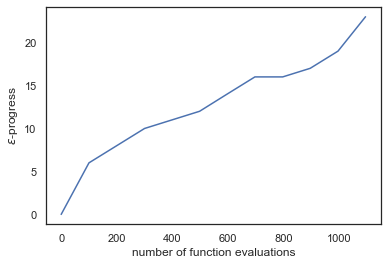

In [23]:
# Create and save convergence plot
fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')
ax.set_xlabel('number of function evaluations')
plt.savefig("images/MORO/MORO_3a_epsilon_convergence.png", dpi=300, bbox_inches='tight',format="png")

In [24]:
# Print the policies in the archive
archive

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,A.3 Total Costs,A.3_Expected Number of Deaths,RfR Total Costs
0,1,1,0,1,1,0,0,1,1,1,...,4,5,9,4,1,7,2,0.000,1.000,0.0
1,1,1,0,1,1,1,0,0,0,0,...,6,1,6,4,3,0,7,0.675,0.625,0.0
2,1,1,0,1,1,1,0,0,0,0,...,10,3,3,7,3,3,3,0.700,0.525,0.0
3,0,0,0,0,1,0,0,0,0,0,...,9,6,2,6,3,0,5,0.500,0.075,1.0
4,0,1,0,0,1,1,0,0,0,0,...,10,1,4,3,3,7,9,0.000,0.950,1.0
5,0,0,0,0,0,0,0,0,0,0,...,10,4,2,7,3,5,4,0.450,0.250,1.0


A parallel axis plot is created with the robust policies, to see how much of the scenarios perform within to the KPI bounds.

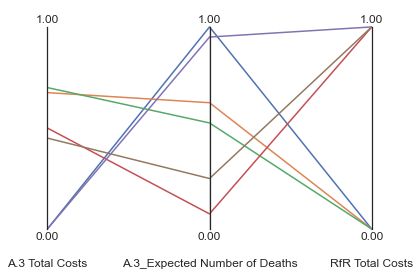

In [25]:
from ema_workbench.analysis import parcoords

# Transform and normalize the results dataframe
data = archive.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

# Create parallel axis plot
paraxes = parcoords.ParallelAxes(limits, fontsize=12, rot=0)
paraxes.plot(data)
plt.savefig("images/MORO/MORO_3b_robust_policies_ParallelAxes.png", dpi=300, bbox_inches='tight',format="png")

The problem is however, that RfR Total Costs is a deterministic outcome which is identical for each scenario given the same policy. This is not ideal, since for each policy, either all the RfR costs are too high (0.0 robustness) or within the required value (1.0 robustness). There is no middle ground in this metric, while it would be preferable to choose the cheaper option when all else is equal.

#### Raw costs as optimization goal

Considering this, the raw costs itself will now be used as an optimization goal. Technically we are now not fully optimizing for robustness, but partly for robustness (A.3 total costs and A.3 expected number of deaths) and partly directly for a KPI direction (low RfR total costs).

In [26]:
import functools

# Create a function to normalize costs to billons
def costs(data):
    return data[0]/1e9 # makes numbers nicer

# Redefine new robustness functions, with the raw RfR total costs
A3_number_of_deaths = functools.partial(robustness, True, A3_deaths_per_year*years)
A3_total_costs = functools.partial(robustness, True, max_A3_total_costs)
RfR_total_costs = costs

When plotting the random policies and scenarios from section 2 in a parallel axis plot, the spread in RfR total cost can be observed.

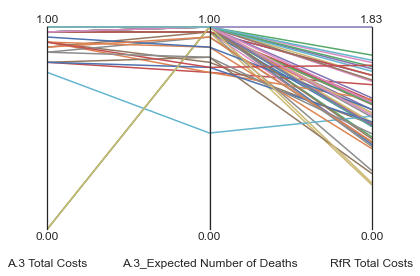

In [27]:
from ema_workbench.analysis import parcoords

# Split the results tuple
experiments, outcomes = results2

# Define function dictionary
funcs = {'A.3 Total Costs': A3_total_costs,
         'A.3_Expected Number of Deaths': A3_number_of_deaths,
         'RfR Total Costs': RfR_total_costs}

# Calculate the scores for each policy
total_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy'] == policy

    temp_outcomes = {k:v[logical] for k,v in outcomes.items() if k in robustness_funcs}

    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

# Transform and normalize the results dataframe
data = pd.DataFrame(total_scores).T.reset_index(drop=True)
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0

# Create parallel axis plot
paraxes = parcoords.ParallelAxes(limits, fontsize=12, rot=0)
paraxes.plot(data)
plt.savefig("images/MORO/MORO_3c_rfr_raw_cost_as_kpi_ParallelAxes.png", dpi=300, bbox_inches='tight',format="png")

We now see that RfR costs is a full spectrum of values instead of only being 1.0 or 0.0.

Note that the RfR costs now mean something different, it's just the costs for each policy, not the fraction of scenarios that fits inside the KPI.

#### Search for robust candidate solution using raw costs as third KPI

If we now run the whole analysis again with the goal of also minimizing the raw RfR costs, instead of only the fraction of scenarios in which is passes, we get the cheapest policies in which there the other KPIs are still acceptable.

In [28]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

funcs = {'A.3 Total Costs': A3_total_costs,
         'A.3_Expected Number of Deaths': A3_number_of_deaths,
         'RfR Total Costs': RfR_total_costs}

robustnes_functions = [ScalarOutcome('A.3 Total Costs', kind=MINIMIZE,
                                     function=A3_total_costs),
                       ScalarOutcome('A.3_Expected Number of Deaths', kind=MINIMIZE,
                                     function=A3_number_of_deaths),
                       ScalarOutcome('RfR Total Costs', kind=MINIMIZE,
                                     function=RfR_total_costs)]

In [29]:
use_pickle4 = True
if use_pickle4:
    with open('data/moro_rob_results4.pickle', 'rb') as filehandler:
        results4 = pickle.load(filehandler)
else:
    convergence = [EpsilonProgress()]

    with MultiprocessingEvaluator(model, n_processes=14) as evaluator:
        results4 = evaluator.robust_optimize(robustnes_functions, scenarios, nfe=nfe, convergence=convergence, epsilons=epsilons, convergence_freq=25, logging_freq=1)
    # Save results in Pickle file
    with open("data/moro_rob_results4.pickle","wb") as filehandler:
        pickle.dump(results4, filehandler)
archive, convergence = results4

Again, we check for epsilon stabilization before processing the results.

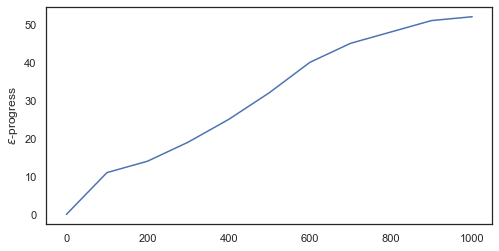

In [30]:
# Create and save convergence plot
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')
plt.savefig("images/MORO/MORO_3d_epsilon_convergence.png", dpi=300, bbox_inches='tight',format="png")

While even more function evaluations would be ideal, the plot convergence enough to show that the solution space has mostly filled with robust, pareto optimal policies.

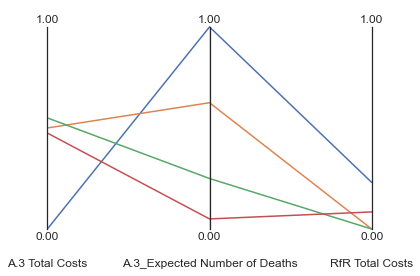

In [31]:
# Transform and normalize the results dataframe
data = archive.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

# Create and save parallel axis plot
paraxes = parcoords.ParallelAxes(limits, fontsize=12, rot=0)
paraxes.plot(data)
plt.savefig("images/MORO/MORO_3e_robust_policies_raw_costs_ParallelAxes.png", dpi=300, bbox_inches='tight',format="png")

From the parallel axis plot it can be seen that different policies perform better on different KPIs. The 4 found policies will be extensively evaluated in the next section, from which more extensive conclusions will be drawn.

## 4. Re-evaluate candidate solutions under uncertainty

Finally, the 4 candidate solution will be evaluated on the KPIs to see how well they perform. Instead of the 40 scenarios used for the robust search, 1000 scenarios will be generated, to not only see convergence but also show some insight into extreme values.

In [32]:
from ema_workbench import Policy

policies = archive.drop([o.name for o in robustnes_functions], axis=1)
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(f"Moro {i}", **policy.to_dict()))
len(policies_to_evaluate)

4

In [33]:
policies.to_csv('data/MORO_rob_polices.csv')

with open("results/moro_robust_policies.pickle", "wb") as filehandler:
    pickle.dump(policies_to_evaluate, filehandler)

Now we will re-evaluate the policies, with 1000 scenarios per policy.

In [34]:
use_pickle5 = True
if use_pickle5:
    with open('data/moro_rob_results5.pickle', 'rb') as filehandler:
        results5 = pickle.load(filehandler)
else:
    n_eva_scenarios = 1000  # Original value: 1000
    with MultiprocessingEvaluator(model, n_processes=14) as evaluator:
        results5 = evaluator.perform_experiments(n_eva_scenarios,
                                                policies_to_evaluate)
        # Save results in Pickle file
        with open("data/moro_rob_results5.pickle","wb") as filehandler:
            pickle.dump(results5, filehandler)
#start = time.time()
#end = time.time()

#print('Processing time:',(end-start)/60,'Minutes')

In [35]:
experiments, outcomes = results5

overall_robustness = {}
plot_outcomes = {o:v for o,v in outcomes.items() if o in robustness_funcs.keys()}

for policy in np.unique(experiments['policy']):
    policy_robustness = {}

    logical = experiments['policy'] == policy
    
    for outcome, values in outcomes.items():
        if outcome in robustness_funcs.keys():
            values = values[logical]
            policy_robustness[outcome] = robustness_funcs[outcome](values)
        overall_robustness[policy] = policy_robustness
overall_robustness = pd.DataFrame.from_dict(overall_robustness).T
overall_robustness

,A.3 Total Costs,A.3_Expected Number of Deaths,RfR Total Costs
Moro 0,0.996,1.000,1.0
Moro 1,0.569,0.999,1.0
Moro 2,0.599,0.605,1.0
Moro 3,0.523,0.441,1.0


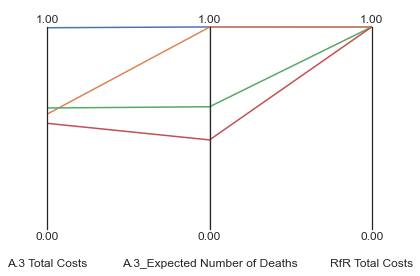

In [36]:
data = overall_robustness.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits, fontsize=12, rot=0)
paraxes.plot(data)
plt.savefig("images/MORO/MORO_4a_robust_policies_evaluation_ParallelAxes.png", dpi=300, bbox_inches='tight',format="png")

#### Deeper analyse KPIs

In [37]:
# Define two functions to get the 5th and 95th quantiles
def q05(x):
    return x.quantile(0.05)

def q95(x):
    return x.quantile(0.95)

In [38]:
outcomes_df = pd.DataFrame.from_dict(outcomes)
KPIs_df = outcomes_df[list(funcs.keys())]
KPIs_df['policy'] = experiments['policy']
KPIs_df.head()

C:\Users\Thomas\AppData\Local\Temp\ipykernel_12140\2066705611.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  KPIs_df['policy'] = experiments['policy']


,A.3 Total Costs,A.3_Expected Number of Deaths,RfR Total Costs,policy
0,1.507462e+08,0.0,230600000.0,Moro 0
1,1.507462e+08,0.0,230600000.0,Moro 0
2,1.507462e+08,0.0,230600000.0,Moro 0
3,1.507462e+08,0.0,230600000.0,Moro 0
4,1.507462e+08,0.0,230600000.0,Moro 0


In [39]:
# Create a Pandas GroupBy object
KPIs_group_df = KPIs_df.groupby(by="policy")

# Create a list of statistical functions which are used
agg_par = ["mean", "min", "max", q05, q95]

# Create new dataframe with the aggegrated data per policy
KPIs_agg_df = KPIs_group_df.agg(agg_par)
KPIs_agg_df.T

policy                                    Moro 0        Moro 1        Moro 2  \
A.3 Total Costs               mean  1.511711e+08  2.842065e+08  2.852278e+08   
                              min   1.507462e+08  8.691433e+07  6.554772e+07   
                              max   2.970348e+08  1.281269e+09  1.792576e+09   
                              q05   1.507462e+08  9.006008e+07  6.554772e+07   
                              q95   1.507462e+08  8.024330e+08  9.975493e+08   
A.3_Expected Number of Deaths mean  2.391128e-04  5.259035e-02  3.903260e-01   
                              min   0.000000e+00  0.000000e+00  0.000000e+00   
                              max   6.504720e-02  2.434688e-01  2.350661e+00   
                              q05   0.000000e+00  1.045237e-03  0.000000e+00   
                              q95   0.000000e+00  1.736701e-01  1.385111e+00   
RfR Total Costs               mean  2.306000e+08  0.000000e+00  0.000000e+00   
                              min   2.306000e+08  0.000000e+00  0.000000e+00   
                              max   2.306000e+08  0.000000e+00  0.000000e+00   
                              q05   2.306000e+08  0.000000e+00  0.000000e+00   
                              q95   2.306000e+08  0.000000e+00  0.000000e+00   

policy                                    Moro 3  
A.3 Total Costs               mean  5.534672e+08  
                              min   2.314024e+07  
                              max   2.771564e+09  
                              q05   4.219114e+07  
                              q95   2.061030e+09  
A.3_Expected Number of Deaths mean  9.460137e-01  
                              min   4.473343e-03  
                              max   3.515631e+00  
                              q05   4.503678e-02  
                              q95   3.441527e+00  
RfR Total Costs               mean  8.460000e+07  
                              min   8.460000e+07  
                              max   8.460000e+07  
                              q05   8.460000e+07  
                              q95   8.460000e+07

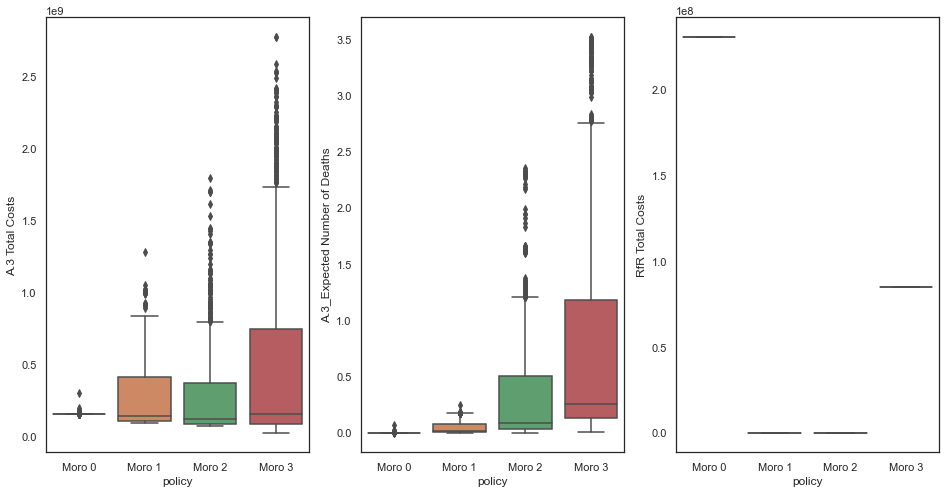

In [40]:
fig, axes = plt.subplots(ncols=3, figsize=(16,8))
KPI_list = list(funcs.keys())
for i, ax in enumerate(axes):
    sns.boxplot(data=KPIs_df[[KPI_list[i], "policy"]], x="policy", y=KPI_list[i], ax=ax)
plt.savefig("images/MORO/MORO_4b_KPI_boxplot.png", dpi=200, bbox_inches='tight',format="png")

#### Evaluating the Moro 0 and 1 policies

In [41]:
outcomes_df['policy'] = experiments['policy']
moro0_df = outcomes_df.loc[outcomes_df["policy"] == "Moro 0"].drop(columns="policy")
moro1_df = outcomes_df.loc[outcomes_df["policy"] == "Moro 1"].drop(columns="policy")

In [42]:
# Create a list of statistical functions which are used
agg_par = ["mean", "min", "max", q05, q95]

# Create new dataframe with the aggegrated data per policy
moro0_agg_df = moro0_df.agg(agg_par)
moro1_agg_df = moro1_df.agg(agg_par)

# Display one
moro0_agg_df.T

,mean,min,max,q05,q95
A.1 Total Costs,2.384176e+08,2.366132e+08,9.199486e+08,2.366132e+08,2.366132e+08
A.1_Expected Number of Deaths,4.833015e-04,0.000000e+00,1.892813e-01,0.000000e+00,0.000000e+00
A.2 Total Costs,2.353325e+08,2.343025e+08,4.089547e+08,2.343025e+08,2.384672e+08
A.2_Expected Number of Deaths,3.683012e-04,0.000000e+00,4.134937e-02,0.000000e+00,1.420623e-03
A.3 Total Costs,1.511711e+08,1.507462e+08,2.970348e+08,1.507462e+08,1.507462e+08
A.3_Expected Number of Deaths,2.391128e-04,0.000000e+00,6.504720e-02,0.000000e+00,0.000000e+00
A.4 Total Costs,4.110705e+07,4.021607e+07,1.383960e+08,4.021607e+07,4.340379e+07
A.4_Expected Number of Deaths,1.687408e-04,0.000000e+00,1.318670e-02,0.000000e+00,6.536062e-04
A.5 Total Costs,1.248485e+08,1.076387e+08,5.053591e+08,1.076387e+08,1.863337e+08
A.5_Expected Number of Deaths,5.932690e-03,0.000000e+00,1.782525e-01,0.000000e+00,2.615909e-02


In [43]:
rings = list(range(1,6))

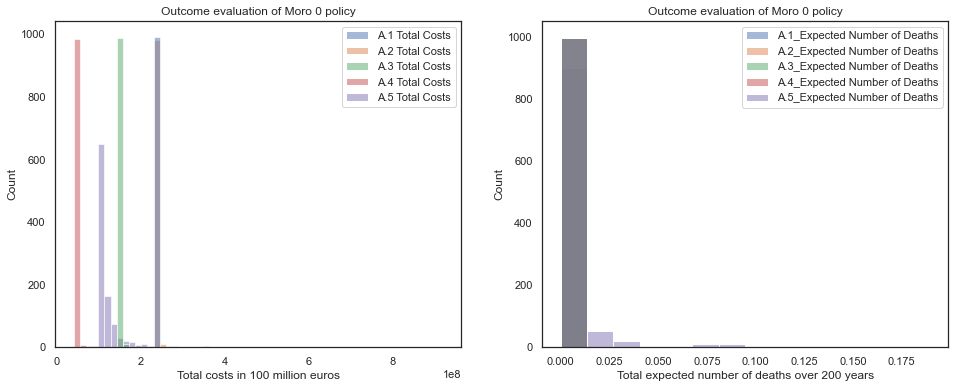

In [44]:
moro0_cost_df = moro0_df[[f"A.{i} Total Costs" for i in rings]]
moro0_deaths_df = moro0_df[[f"A.{i}_Expected Number of Deaths" for i in rings]]

xlabels = ["Total costs in 100 million euros", "Total expected number of deaths over 200 years"]

fig, axes = plt.subplots(ncols=2, figsize=(16,6), sharex=False, sharey=False)
for i, df in enumerate([moro0_cost_df, moro0_deaths_df]):
    g = sns.histplot(data=df, ax=axes[i])
    g.set_title("Outcome evaluation of Moro 0 policy")
    g.set_xlabel(xlabels[i])
plt.savefig("images/MORO/MORO_4c_Moro_0_histplot.png", dpi=200, bbox_inches='tight',format="png")

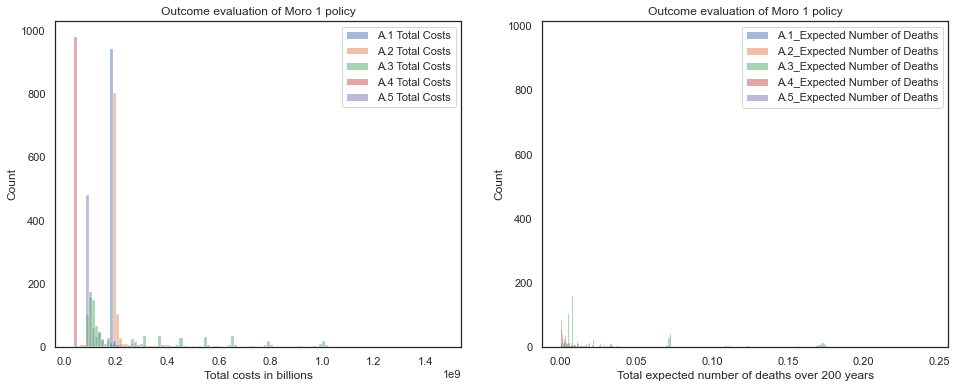

In [45]:
moro1_cost_df = moro1_df[[f"A.{i} Total Costs" for i in rings]]
moro1_deaths_df = moro1_df[[f"A.{i}_Expected Number of Deaths" for i in rings]]

xlabels = ["Total costs in billions", "Total expected number of deaths over 200 years"]

fig, axes = plt.subplots(ncols=2, figsize=(16,6), sharex=False, sharey=False)
for i, df in enumerate([moro1_cost_df, moro1_deaths_df]):
    g = sns.histplot(data=df, ax=axes[i])
    g.set_title("Outcome evaluation of Moro 1 policy")
    g.set_xlabel(xlabels[i])
plt.savefig("images/MORO/MORO_4c_Moro_1_histplot.png", dpi=300, bbox_inches='tight',format="png")